In [17]:
# Imports

from datetime import datetime, timezone
from utils import records, did_from_uri
import matplotlib.pyplot as plt

from IPython.display import display, HTML

In [46]:
# Constants

IN_DIR = "../data/firehose-2023-05-01"

REFRESH_SIZE = 20
MAX_POSTS_PER_USER = 60
MAX_POSTS_PER_SESSION = REFRESH_SIZE * 1
END_DATE = datetime(2023, 1, 1, tzinfo=timezone.utc)

SESSION_IDLE_THRESHOLD = 30  # minutes

In [50]:
USER: str = "did:plc:oky5czdrnfjpqslsw2a5iclo"

last_interaction_ts = None
notifs = []
actions = []
sessions = []


def is_new_session(now_ts: int, idle_threshold: int = SESSION_IDLE_THRESHOLD) -> bool:
    if last_interaction_ts is None:
        return True

    mins_since_last_record = (now_ts - last_interaction_ts) / 60_000
    return mins_since_last_record > idle_threshold


for record in records(IN_DIR, end_date=END_DATE):
    # User actions
    if record["did"] == USER:
        actions.append(record)
        # TODO: Session handling
        if is_new_session(record["ts"]):
            if last_interaction_ts is not None:
                print(
                    "New session! Time since last interaction: ",
                    (record["ts"] - last_interaction_ts) / 60_000,
                )
            else:
                print("First session!")
            sessions.append({"start": record["ts"], "end": record["ts"]})
        else:
            print(
                "Not new session! Time since last interaction: ",
                (record["ts"] - last_interaction_ts) / 60_000,
            )

        last_interaction_ts = record["ts"]
        sessions[-1]["end"] = record["ts"]
        continue

    # Notifications
    else:
        if record["$type"] == "app.bsky.feed.post":
            if "reply" in record and record["reply"]:
                try:
                    root_did = did_from_uri(record["reply"]["root"]["uri"])
                    parent_did = did_from_uri(record["reply"]["parent"]["uri"])

                    if root_did == USER:
                        notifs.append(record)
                    if parent_did == USER and parent_did != root_did:
                        notifs.append(record)

                except ValueError:
                    print("Invalid URI, ", record)

        if record["$type"] == "app.bsky.feed.like":
            subject_did = did_from_uri(record["subject"]["uri"])
            if subject_did == USER:
                notifs.append(record)

        if record["$type"] == "app.bsky.graph.follow":
            if record["subject"] == USER:
                notifs.append(record)

        if record["$type"] == "app.bsky.feed.repost":
            subject_did = did_from_uri(record["subject"]["uri"])
            if subject_did == USER:
                notifs.append(record)

  0%|          | 0/9 [00:01<?, ?it/s]

First session!
New session! Time since last interaction:  356.39841666666666
Not new session! Time since last interaction:  0.8845666666666666
Not new session! Time since last interaction:  0.016866666666666665
Not new session! Time since last interaction:  0.0083
Not new session! Time since last interaction:  0.011666666666666667
New session! Time since last interaction:  650.3216166666666
Not new session! Time since last interaction:  0.02265
Not new session! Time since last interaction:  0.04176666666666667
Not new session! Time since last interaction:  0.28123333333333334
Not new session! Time since last interaction:  1.16345
New session! Time since last interaction:  410.889
Not new session! Time since last interaction:  0.1766
Not new session! Time since last interaction:  0.022983333333333335
New session! Time since last interaction:  77.64948333333334
Not new session! Time since last interaction:  0.08486666666666667
Not new session! Time since last interaction:  3.592866666666

In [44]:
(sessions[4]["end"] - sessions[4]["start"]) / 60_000

16.486033333333335

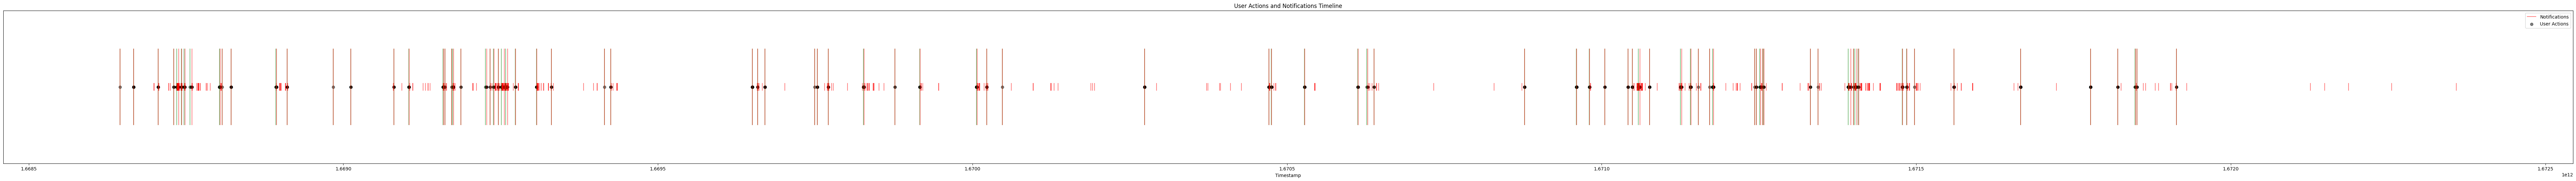

In [51]:
# Create scatter plot of notifications and actions over time
plt.figure(figsize=(100, 6))

# Plot notifications in red
notif_times = [n["ts"] for n in notifs]
plt.vlines(
    notif_times, ymin=0.95, ymax=1.05, color="red", alpha=0.5, label="Notifications"
)

# Plot session spans with shaded regions
for session in sessions:
    # plt.axvspan(
    #     session["start"],
    #     session["end"],
    #     alpha=0.2,
    #     color="blue",
    #     label="Session" if session == sessions[0] else "",
    #     ymin=0.5,
    #     ymax=1.5,
    # )
    plt.vlines(
        session["start"],
        ymin=0.5,
        ymax=1.5,
        colors="green",
        alpha=0.5,
    )
    plt.vlines(
        session["end"],
        ymin=0.5,
        ymax=1.5,
        colors="red",
        alpha=0.5,
    )


# notif_times = [n["ts"] for n in notifs]
# plt.vlines(
#     notif_times, ymin=0.95, ymax=1.05, color="red", alpha=0.5, label="Notifications"
# )

# # Plot user actions in black
action_times = [a["ts"] for a in actions]
plt.scatter(
    action_times,
    [1] * len(action_times),
    color="black",
    alpha=0.5,
    label="User Actions",
)

plt.ylim(0, 2)

plt.xlabel("Timestamp")
plt.yticks([])  # Hide y-axis ticks since we're just showing events
plt.title("User Actions and Notifications Timeline")
plt.legend()

plt.savefig("wide_plot_for_html.png", bbox_inches="tight", dpi=500)
plt.show()